https://www.kaggle.com/blacksix/concorde-for-5-hours

In [ ]:
%%bash -e
if ! [[ -f ./linkern ]]; then
  wget http://www.math.uwaterloo.ca/tsp/concorde/downloads/codes/src/co031219.tgz
  echo 'c3650a59c8d57e0a00e81c1288b994a99c5aa03e5d96a314834c2d8f9505c724  co031219.tgz' | sha256sum -c
  tar xf co031219.tgz
  (cd concorde && CFLAGS='-O3 -march=native -mtune=native -fPIC' ./configure)
  (cd concorde/LINKERN && make -j && cp linkern ../../)
  rm -rf concorde co031219.tgz
fi

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy
from numba import jit

In [3]:
cities = pd.read_csv('input/cities.csv', index_col=['CityId'])

In [4]:
cities1k = cities * 1000

In [5]:
def write_tsp(cities, filename, name='traveling-santa-2018-prime-paths'):
    with open(filename, 'w') as f:
        f.write('NAME : %s\n' % name)
        f.write('COMMENT : %s\n' % name)
        f.write('TYPE : TSP\n')
        f.write('DIMENSION : %d\n' % len(cities))
        f.write('EDGE_WEIGHT_TYPE : EUC_2D\n')
        f.write('NODE_COORD_SECTION\n')
        for row in cities.itertuples():
            f.write('%d %.11f %.11f\n' % (row.Index+1, row.X, row.Y))
        f.write('EOF\n')

write_tsp(cities1k, 'cities1k.tsp')

-s <seed> - random seed  
-S <file> - saving the tour periodically in this file  
-R 999999999 - repeat LK rounds (almost) indefinitely  
-t <seconds> - bound by time instead  

In [6]:
%%bash -e
time ./linkern -s 42 -S linkern.tour -R 1000000000 -t 18000 ./cities1k.tsp >linkern.log
# 5h 0m 18s


real	300m17.587s
user	300m1.343s
sys	0m15.909s


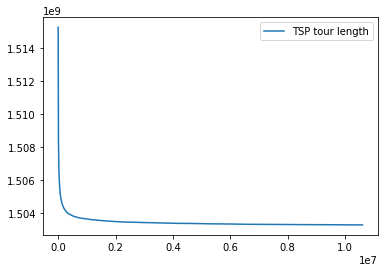

In [7]:
!sed -Ene 's/([0-9]+) Steps.*Best: ([0-9]+).*/\1,\2/p' linkern.log >linkern.csv
pd.read_csv('linkern.csv', index_col=0, names=['TSP tour length']).plot();

In [8]:
def read_tour(filename):
    tour = open(filename).read().split()[1:]
    tour = list(map(int, tour))
    if tour[-1] == 0: tour.pop()
    return tour

def score_tour(tour):
    df = cities.reindex(tour + [0]).reset_index()
    primes = list(sympy.primerange(0, len(cities)))
    df['prime'] = df.CityId.isin(primes).astype(int)
    df['dist'] = np.hypot(df.X - df.X.shift(-1), df.Y - df.Y.shift(-1))
    df['penalty'] = df['dist'][9::10] * (1 - df['prime'][9::10]) * 0.1
    return df.dist.sum() + df.penalty.sum()

def write_submission(tour, filename):
    assert set(tour) == set(range(len(tour)))
    pd.DataFrame({'Path': list(tour) + [0]}).to_csv(filename, index=False)

In [9]:
tour = read_tour('linkern.tour')
score_tour(tour)
# 1516845.1618924788
# 1516912.3751145517

1516845.1618924788

In [10]:
write_submission(tour, 'submission_5h.csv')

# plt.figure(figsize=(20, 20))
# plt.plot(cities.X[tour], cities.Y[tour], alpha=0.7)
# plt.show()